OURunning Through EAZY Py and producing fitting templates to a given ZFOURGE catalogue

In [60]:

%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import eazy.hdf5
import time
import importlib
import sys
import eazy

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
print('EAZYCODE = '+ str(os.getenv('EAZYCODE')) + '\n')

print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy']:
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

EAZYCODE = None

Tue Apr 16 15:58:18 2024

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]

               numpy : 1.22.3
               scipy : 1.7.3
          matplotlib : 3.8.0
             astropy : 5.3.4
                eazy : 0.6.8


Loading the ZFOURGE catalogue locally and running it through EAZY

Basic Settings Cell, can find more in depth changes further down

In [97]:
# Load ZFOURGE catalogue from local drive
field = 'cdfs' #'cdfs', 'cosmos', or 'uds'

# Choose ID key for the catalogue
# A key designates what type of test you want to occur
id_key = 'normal' # normal, high or low
id_range = {'normal': (0,30000),
           'high': (18000,20000),
           'low': (6000,10000)}

# AGN templates allocation
agn_sed = [1,2,3,4] # AGN templates to be added
use_galaxy_templates = True # set to True to use galaxy templates as well

In [98]:
# making an agn catalogue with only selected range of objects

# Read the catalogue
os.getcwd()
object_range = id_range[id_key] # range of objects to be selected, determined by the key
agn_cat1 = sorted(glob.glob(f'zfourge/{field}/{field}.v?.?.??.cat')) # finds the catalogue
agn_cat2 = pd.read_csv(agn_cat1[0])
agn_cat_cut = agn_cat2[object_range[0]:object_range[1]] # select a range of objects with considerable content
agn_cat_cut.to_csv(f'inputs/cdfs_eazy_test.cat', index=False) # create a new catalogue with the selected objects

# Some analysis
agn_data1 = glob.glob(f'zfourge/{field}/{field}.v*.agn.*cat')
agn_data2 = pd.read_csv(agn_data1[0], sep="\s+", comment='#', header=None)[object_range[0]:object_range[1]]
total_count = object_range[1] - object_range[0] # all objects in the range

# total count
ids = []
for column in agn_data2.columns[1:]:  # Skip the first column (column of IDs)
    ids.extend(agn_data2.loc[agn_data2[column] == 1, 0].tolist())
ids = list(set(ids))
total_agn = len(ids) # all objects in the range that are AGN

ir_count = agn_data2[1].value_counts().get(1, 0)
ir_percent = ir_count/total_agn
radio_count = agn_data2[2].value_counts().get(1, 0)
radio_percent = radio_count/total_agn
xray_count = agn_data2[3].value_counts().get(1, 0)
xray_percent = xray_count/total_agn

# print the stats
print(f'Total number of objects: {total_count}')
print(f'Number of IR objects: {ir_count} ({ir_percent:.2%})')
print(f'Number of radio objects: {radio_count} ({radio_percent:.2%})')
print(f'Number of X-ray objects: {xray_count} ({xray_percent:.2%})')
print(f'Total number of AGN: {total_agn} ({total_agn/total_count:.2%})')

Total number of objects: 30000
Number of IR objects: 80 (27.40%)
Number of radio objects: 15 (5.14%)
Number of X-ray objects: 234 (80.14%)
Total number of AGN: 292 (0.97%)


In [99]:
# Load any templates from the AGN template library

temp_param = 'templates/eazy_v1.3.spectra.param' # basic parameter file, no agn templates
empty_param = 'templates/eazy_v1.3_empty.param' # empty parameter file
last_id = 9 # last id in the parameter file
agn_param = 'templates/eazy_v1.3_AGN.param' # parameter file with agn templates

# opening the parameter files, and reading the contents
with open(temp_param) as f:
    original_galaxy = f.read()

with open(empty_param) as f:
    original_empty = f.read()

agn_dir = 'templates/hlsp_agnsedatlas_observed/' # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)
def agn_template_loader(templates, use_galaxy_templates=False):
    if use_galaxy_templates:
      copy = original_galaxy
      no_of_templates = len(templates)
      if no_of_templates == 0:
        print('No AGN templates added, just using galaxy templates')
        return
      for i in range(no_of_templates):
        id = last_id + i
        copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
      open(agn_param, 'w').write(copy)
      print(f'AGN templates added to the parameter file {agn_param}, {last_id} galaxy templates used')
      return
    else:
      copy = original_empty
      no_of_templates = len(templates)
      if no_of_templates == 0:
        print('No AGN templates added, no templates used')
        return
      for i in range(no_of_templates):
        id = 0 + i
        copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
      open(agn_param, 'w').write(copy)
      print(f'AGN templates added to the parameter file {agn_param}, no galaxy templates used')
      return

In [100]:
# EAZY parameters

# following files should be in the same dir as the project
param_file = f'base.param' #base parameter file, does not include all information
translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate')

agn_template_loader(agn_sed, use_galaxy_templates=use_galaxy_templates) # loads the chosen AGN templates to the parameter file

params = {} # setting field specific parameters
params['Z_STEP'] = 0.05 # redshift step, defines the precision of each fit
params['TEMPLATES_FILE'] = 'templates/eazy_v1.3_AGN.param' # parameter file containing which templates will be used
params['CACHE_FILE'] = f'zfourge/{field}/{field}.tempfilt'
params['CATALOG_FILE'] = f'inputs/{field}_eazy_test.cat' # for cut catalogue created in the earlier cell
params['MAIN_OUTPUT_FILE'] = f'outputs/{field}/{id_key}/{field}_{id_key}_{agn_sed}_{use_galaxy_templates}' # output file


AGN templates added to the parameter file templates/eazy_v1.3_AGN.param, 9 galaxy templates used


In [101]:
# Run EAZY with parameters

self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file[0], zeropoint_file=None,
                         params=params, load_prior=True, load_products=False)

Read default param file: base.param
Read CATALOG_FILE: inputs/cdfs_eazy_test.cat
   >>> NOBJ = 30000
f_IRAC_80 e_IRAC_80 ( 21): IRAC/irac_tr4_2004-08-09.dat
f_IRAC_58 e_IRAC_58 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC_45 e_IRAC_45 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC_36 e_IRAC_36 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_Ks e_Ks (255): FOURSTAR/Ks_cam_optics_sky.txt
f_KsHI e_KsHI (269): VLT/hawki_k_ETC.dat
f_J1 e_J1 (249): FOURSTAR/J1_cam_optics_sky.txt
f_J2 e_J2 (250): FOURSTAR/J2_cam_optics_sky.txt
f_J3 e_J3 (251): FOURSTAR/J3_cam_optics_sky.txt
f_Hs e_Hs (254): FOURSTAR/Hshort_cam_optics_sky.txt
f_Hl e_Hl (253): FOURSTAR/Hlong_cam_optics_sky.txt
f_U e_U (103): ESO/vimos_u.res
f_B e_B (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_V e_V (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_I e_I (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_Z e_Z (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_F140W e_F140W

100%|██████████| 13/13 [00:16<00:00,  1.25s/it]


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Template   7: c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat (NZ=1).
Template   8: erb2010_highEW.dat (NZ=1).
Template   9: hlsp_agnsedatlas_multi_multi_3c120_multi_v1_spec-obs.dat (NZ=1).
Template  10: hlsp_agnsedatlas_multi_multi_3c273_multi_v1_spec-obs.dat (NZ=1).
Template  11: hlsp_agnsedatlas_multi_multi_3c351_multi_v1_spec-obs.dat (NZ=1).
Template  12: hlsp_agnsedatlas_multi_multi_3c390-3_multi_v1_spec-obs.dat (NZ=1).
Process templates: 17.228 s


48it [00:01, 37.55it/s]


Iteration:  0


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Compute best fits
fit_best: 5.5 s (n_proc=2,  NOBJ=28356)
Fit 29.7 s (n_proc=8, NOBJ=28825)
Iterative correction - zeropoint / template
Iteration:  1


100%|██████████| 48/48 [00:25<00:00,  1.91it/s]


Compute best fits
fit_best: 5.7 s (n_proc=2,  NOBJ=28371)
Fit 31.3 s (n_proc=8, NOBJ=28825)
Iterative correction - zeropoint / template
Iteration:  2


100%|██████████| 48/48 [00:25<00:00,  1.89it/s]


Compute best fits
fit_best: 5.8 s (n_proc=2,  NOBJ=28378)
Fit 31.6 s (n_proc=8, NOBJ=28825)
Iterative correction - zeropoint / template


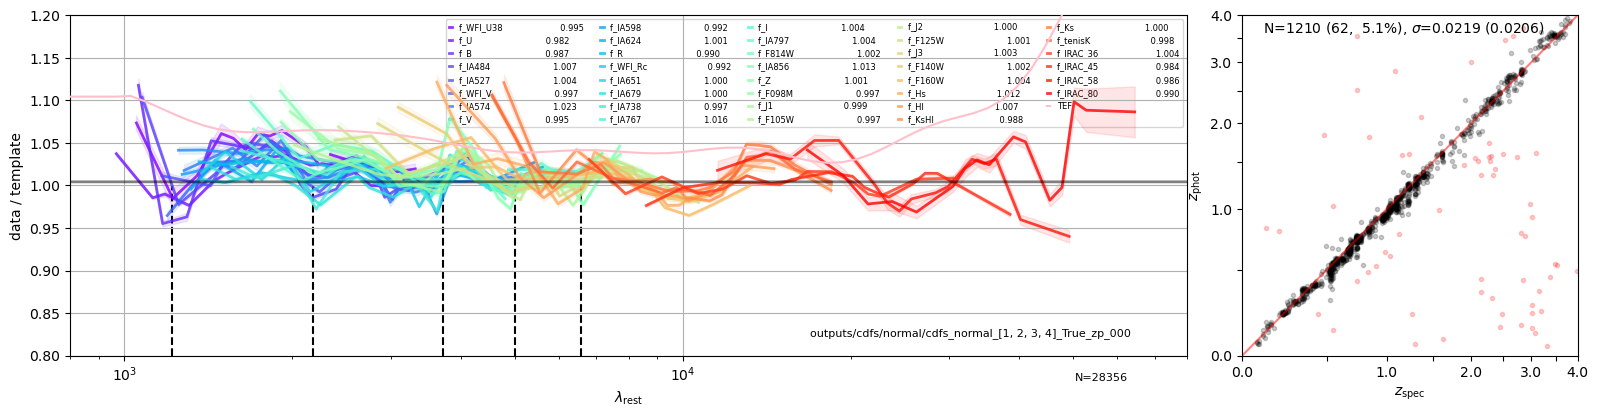

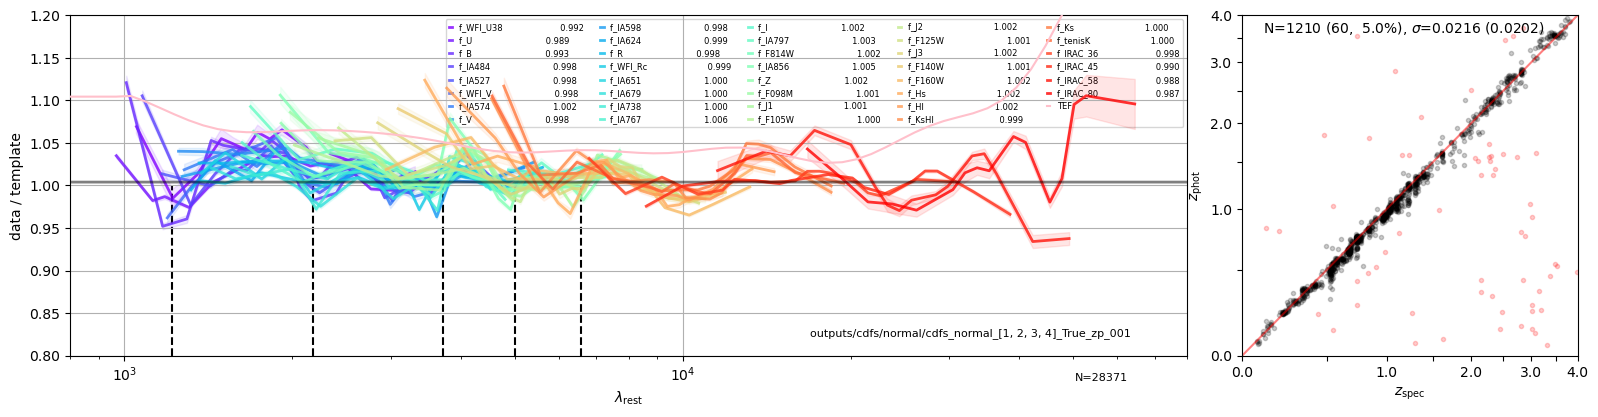

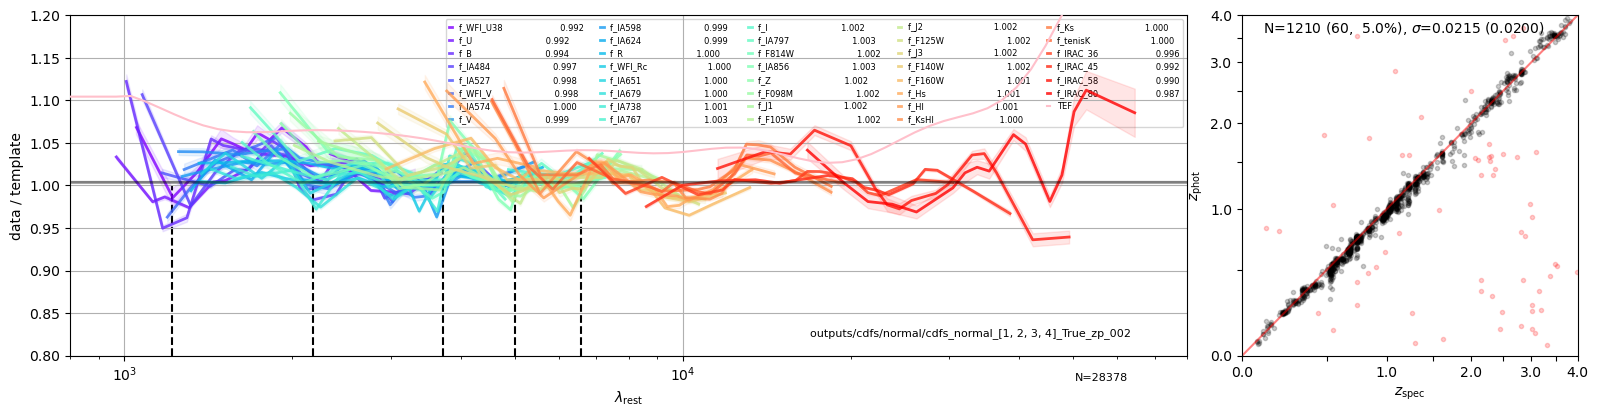

In [102]:
# Iterative Zero-point corrections

NITER = 3 # no. of iterations
NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

for iter in range(NITER):
    print('Iteration: ', iter)

    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                              update_zeropoints=True, iter=iter, n_proc=8,
                              save_templates=False, error_residuals=False,
                              NBIN=NBIN, get_spatial_offset=False)

Set sys_err = 0.00 (positive=True)


100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Compute best fits
fit_best: 6.1 s (n_proc=2,  NOBJ=29286)
Fit 35.9 s (n_proc=8, NOBJ=30000)


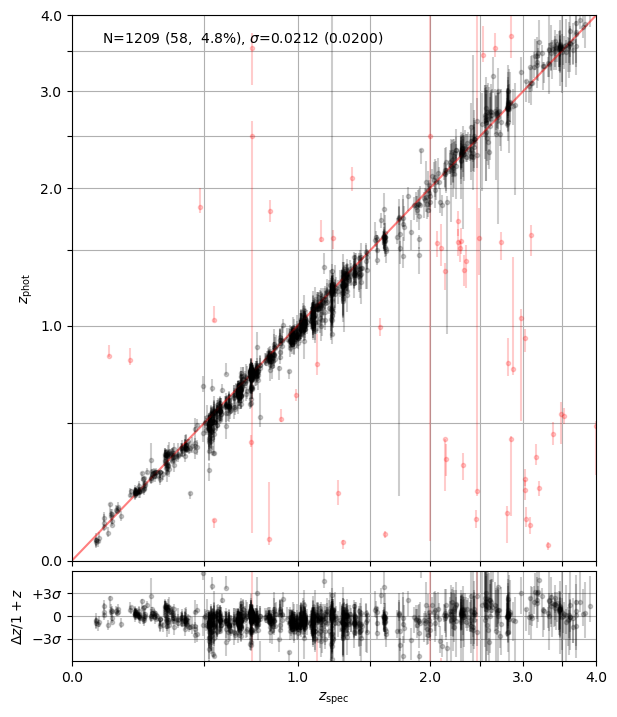

In [117]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

# Show zspec-zphot comparison
fig = self.zphot_zspec()

Counts: [  5  11   5  26  28  61 101 285 139 229  70 102  97  56   6]
Total: 1221
NMAD: [0.0065811948920653195, 0.017926241341152206, 0.0055161071279411795, 0.0035699991719186797, 0.007708732623259226, 0.013532290918365858, 0.028910380390391805, 0.014567099068045878, 0.025922355572200052, 0.026482181138233554, 0.0404338195191711, 0.05500825905369761, 0.1495665224759584, 0.10033185570644572, 0.11235642031181799]


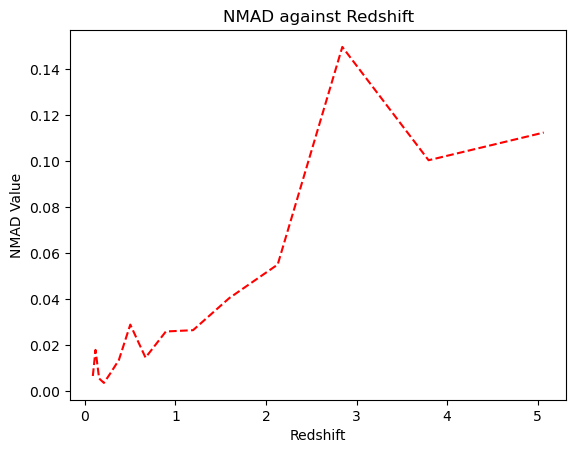

In [121]:
# NMAD calculation and plot

def nmad(spec, phot):
    spec = np.array(spec)
    phot = np.array(phot)
    delta_z = np.abs(phot-spec)
    return 1.48 * np.median(np.abs(delta_z - np.median(delta_z) / (1+spec)))

combined = list(zip(self.ZSPEC, self.zbest))
filtered = [(x, y) for x, y in combined if x > 0]
sorted_filtered = sorted(filtered, key=lambda x: x[0])
zspec_sorted, zphot_sorted = zip(*sorted_filtered)

no_of_bins = 15 # no. of bins

logbins_start = np.log10(min(zspec_sorted)) # using logarithmic bins
logbins_end = np.log10(max(zspec_sorted)) + 1e-10 # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins+1)
counts, bins = np.histogram(zspec_sorted, bins=logbins)
bin
print(f'Counts: {counts}')
print(f'Total: {len(zspec_sorted)}')


last_val = 0
nmad_val = []
for bin in range(no_of_bins):
    new_val = last_val + counts[bin]-1
    zspec_val = zspec_sorted[last_val:new_val]
    zphot_val = zphot_sorted[last_val:new_val]
    nmad_val.append(nmad(zspec_val, zphot_val))
    last_val = new_val + 1
print(f'NMAD: {nmad_val}')

bin_centers = (np.array(bins[:-1]) + np.array(bins[1:])) / 2
plt.plot(bin_centers, nmad_val, 'r--')  # 'r--' specifies a red dashed line

plt.xlabel('Redshift')
plt.ylabel('NMAD Value')

plt.title('NMAD against Redshift')

plt.show()

In [105]:
# Saving Key data to csv
key_data_file = f'outputs/{field}/key_data.csv'
headings = ['id_key', 'abn_templates', 'galaxy templates', 'total_obj', 'total_agn', 'total_agn_percent', 'ir_count', 'ir_percent', 'radio_count', 'radio_percent', 'xray_count', 'xray_percent', 'nmad_val']
key_data = pd.DataFrame(columns=headings)
key_data.loc[0] = [id_key, agn_sed, use_galaxy_templates, total_count, total_agn, total_agn/total_count, ir_count, ir_percent, radio_count, radio_percent, xray_count, xray_percent, nmad_val]

# Check if the file exists
if not os.path.isfile(key_data_file):
    # If the file doesn't exist, create it
    key_data.to_csv(key_data_file, index=False, header=True)
else:
    # If the file exists, append without writing the header
    key_data.to_csv(key_data_file, mode='a', index=False, header=False)

In [106]:
 # Derived parameters (z params, RF colors, masses, SFR, etc.)
warnings.simplefilter('ignore', category=RuntimeWarning)
zout, hdu = self.standard_output(simple=False,
                                 rf_pad_width=0.5, rf_max_err=2,
                                 prior=True, beta_prior=True,
                                 absmag_filters=[],
                                 extra_rf_filters=[])
# zout is also saved to the designated zout file in the parameter file

Get best fit coeffs & best redshifts
fit_best: 16.1 s (n_proc=2,  NOBJ=29539)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 29539/29539 [05:14<00:00, 93.98it/s]



 Couldn't find template parameters file templates/eazy_v1.3_AGN.param.fits for population synthesis 
 calculations.
            


Text(0, 0.5, '$(U-V)_0$')

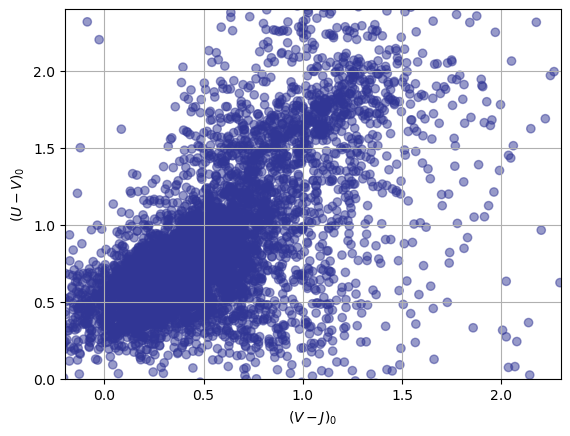

In [107]:
# Show UVJ diagram
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])
ssfr = zout['sfr']/zout['mass']

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel],
            vmin=-13, vmax=-8, alpha=0.5, cmap='RdYlBu')

plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')

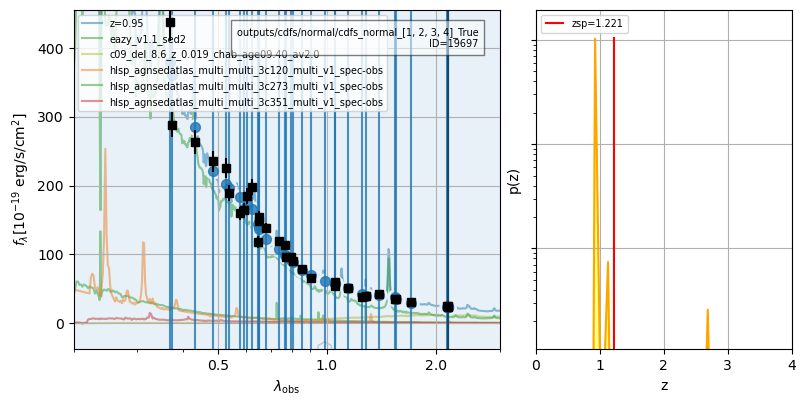

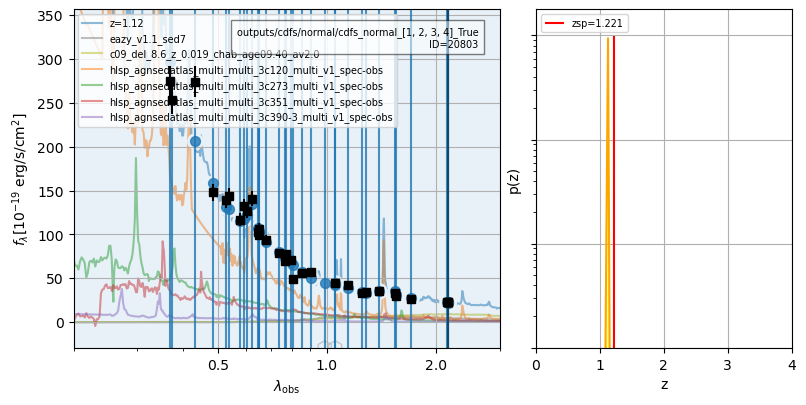

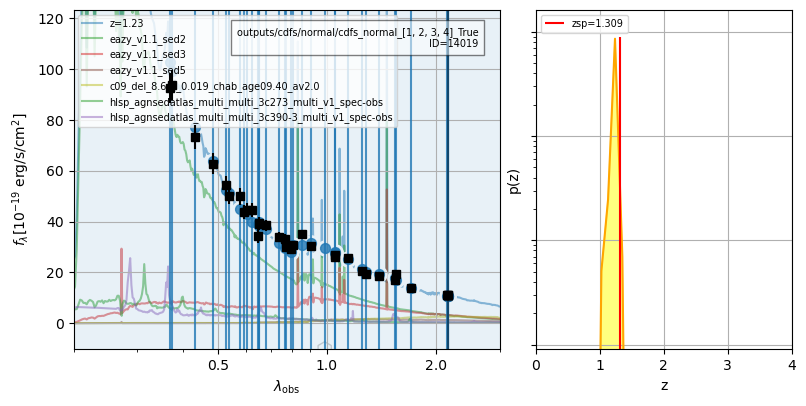

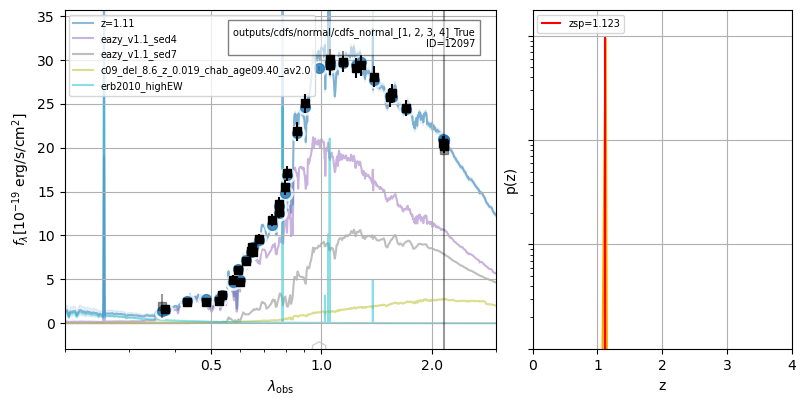

In [108]:
# Show brightest objects with z_spec > 1

ifilter = self.flux_columns[np.argmin((self.lc - 8140)**2)]

imag = 25 - 2.5*np.log10(self.cat[ifilter])
sel = (self.ZSPEC > 1.1)

so = np.argsort(imag[sel])
ids = self.OBJID[sel][so]

for i in range(4):
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], show_components=True,
                              logpz=True, zr=[0,4])

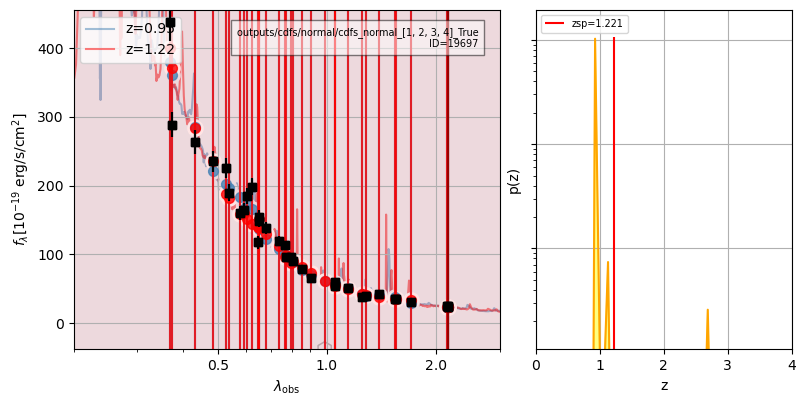

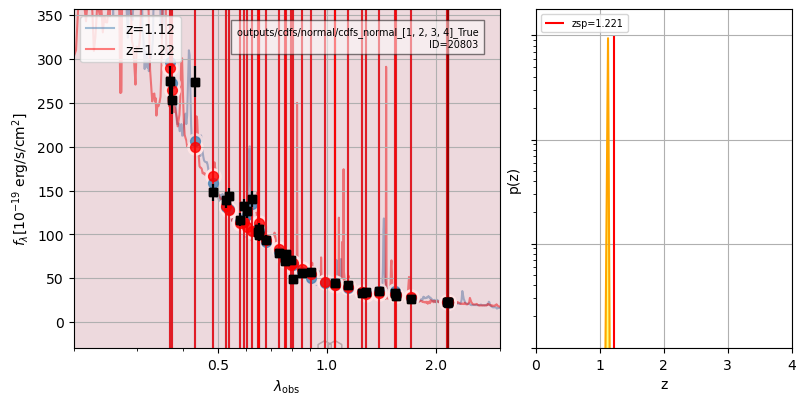

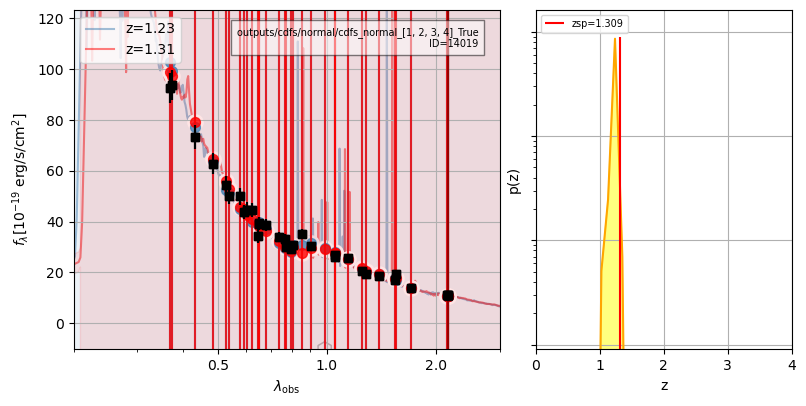

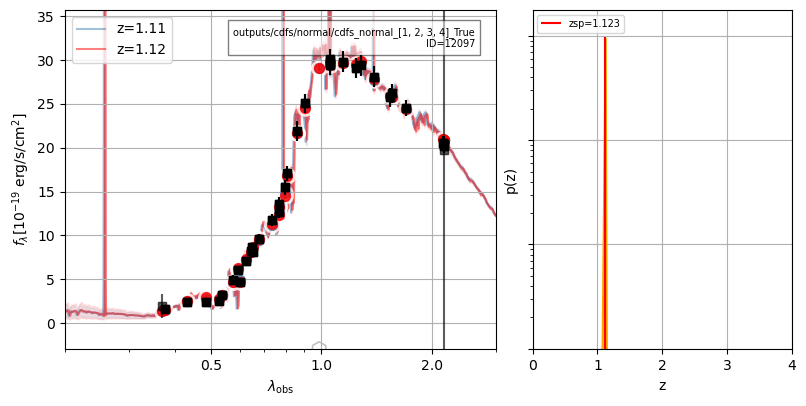

In [109]:
# Compare forced fit at z_spec
for i in range(4):
    ix = np.where(self.OBJID == ids[i])[0][0]
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3],
                        show_components=False,
                        template_color='steelblue', logpz=True, zr=[0,4])

    # Now show with z_spec
    axes = fig.axes[:1]
    res = self.show_fit(ids[i], xlim=[0.2, 3], axes=axes,
                        zshow=self.ZSPEC[ix],
                        show_components=False,
                        template_color='r')

    axes[0].legend(loc='upper left')

In [110]:
zout.meta

OrderedDict([('version', ('0.6.8', 'Eazy-py version')),
             ('prior', (True, 'Prior applied (templates/prior_K_TAO.dat)')),
             ('betprior', (True, 'Beta prior applied')),
             ('fitter', ('nnls', 'Optimization method for template fits')),
             ('SYS_ERR', 0.0),
             ('TEMP_ERR_FILE', 'templates/TEMPLATE_ERROR.v2.0.zfourge'),
             ('TEMP_ERR_A2', 1.0),
             ('PRIOR_FILTER', 255.0),
             ('PRIOR_ABZP', 25.0),
             ('IGM_SCALE_TAU', 1.0),
             ('APPLY_IGM', 'y'),
             ('TEMPLATES_FILE', 'templates/eazy_v1.3_AGN.param'),
             ('TEMPL000', 'eazy_v1.1_sed1.dat'),
             ('TEMPL001', 'eazy_v1.1_sed2.dat'),
             ('TEMPL002', 'eazy_v1.1_sed3.dat'),
             ('TEMPL003', 'eazy_v1.1_sed4.dat'),
             ('TEMPL004', 'eazy_v1.1_sed5.dat'),
             ('TEMPL005', 'eazy_v1.1_sed6.dat'),
             ('TEMPL006', 'eazy_v1.1_sed7.dat'),
             ('TEMPL007', 'c09_del_8.6_z_0.

In [111]:
zout.info()

<Table length=30000>
    name      dtype  shape       unit       format        description         n_bad
------------ ------- ----- ---------------- ------ -------------------------- -----
          id   int32                                                              0
          ra float64                                                              0
         dec float64                                                              0
      z_spec float64                                                              0
    nusefilt   int32                                                              0
        z_ml float32                                                              0
   z_ml_chi2 float32                                                              0
   z_ml_risk float32                                                              0
      lc_min float64                           .1f                                0
      lc_max float64                           .1f     

In [112]:
eazy.hdf5.write_hdf5(self, h5file=self.param['MAIN_OUTPUT_FILE'] + '.h5')

h5: create file outputs/cdfs/normal/cdfs_normal_[1, 2, 3, 4]_True.h5
h5: cat/flux_columns
h5: cat/err_columns
h5: cat/f_numbers
h5: cat/fnu
h5: cat/efnu_orig
h5: cat/ok_data
h5: cat/zp
h5: cat/ext_corr
h5: cat/ext_redden
h5: cat/pivot
h5: fit/zml
h5: fit/zbest
h5: fit/chi2_fit
h5: fit/coeffs_best
h5: fit/fit_coeffs
h5: templates/eazy_v1.1_sed1.dat
h5: templates/eazy_v1.1_sed2.dat
h5: templates/eazy_v1.1_sed3.dat
h5: templates/eazy_v1.1_sed4.dat
h5: templates/eazy_v1.1_sed5.dat
h5: templates/eazy_v1.1_sed6.dat
h5: templates/eazy_v1.1_sed7.dat
h5: templates/c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat
h5: templates/erb2010_highEW.dat
h5: templates/hlsp_agnsedatlas_multi_multi_3c120_multi_v1_spec-obs.dat
h5: templates/hlsp_agnsedatlas_multi_multi_3c273_multi_v1_spec-obs.dat
h5: templates/hlsp_agnsedatlas_multi_multi_3c351_multi_v1_spec-obs.dat
h5: templates/hlsp_agnsedatlas_multi_multi_3c390-3_multi_v1_spec-obs.dat
